# AI-3: Natural Language Processing
## PROJECT: IMAGE CAPTIONING FOR ACADEMIC AND SCIENTIFIC PLOTS AND FIGURES

**AI3 Cohort 2**<br/>
**Univ.AI**<br/>
**Instructor**: Prof. Pavlos Protopapas<br />

<hr style="height:2.4pt">

## Names of the people who worked on this project together
**<font color='red'>Bhaskar Bharat, Ekanki Agarwal, Prerna Mahajan and Viraj Kadam</font>**

# Visual Attention Trained on Univ AI Dataset

Since the plots in SCICAP Dataset do not contain very distinguishing features but have captions very different than the others, therefore the performance of our models in the previous two notebooks has suffered because of this inherent problem with the dataset.

Therefore, in this notebook we are trying to train our Visual Attention model directly on the Univ_AI_Dataset. This is a dataset that we have curated using lecture slides from courses AI-1, AI-2, DS-1 and DS-2. We generate captions on new images using this model and evaluate the performance using [BLEU-4](https://cloud.google.com/translate/automl/docs/evaluate#bleu) scores and see if the performance improves.

In [87]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [88]:
import tensorflow as tf

# You'll generate plots of attention in order to see which parts of an image
# your model focuses on during captioning
import matplotlib.pyplot as plt

import collections
import random
import numpy as np
import os
import time
import json
import pickle
from PIL import Image

from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

## Download and prepare the univ_ai_dataset

In [89]:
!unzip "/content/drive/MyDrive/Colab Notebooks/AI-3/Project/AI-3 Project Dataset bobbig/univ_ai_dataset.zip"

Archive:  /content/drive/MyDrive/Colab Notebooks/AI-3/Project/AI-3 Project Dataset bobbig/univ_ai_dataset.zip
replace univ_ai_dataset/captions/captions.json? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: univ_ai_dataset/captions/captions.json  
  inflating: univ_ai_dataset/captions/captions.txt  
  inflating: univ_ai_dataset/images/ekanki-image-1.png  
  inflating: univ_ai_dataset/images/ekanki-image-10.png  
  inflating: univ_ai_dataset/images/ekanki-image-100.png  
  inflating: univ_ai_dataset/images/ekanki-image-11.png  
  inflating: univ_ai_dataset/images/ekanki-image-12.png  
  inflating: univ_ai_dataset/images/ekanki-image-13.png  
  inflating: univ_ai_dataset/images/ekanki-image-14.png  
  inflating: univ_ai_dataset/images/ekanki-image-15.png  
  inflating: univ_ai_dataset/images/ekanki-image-16.png  
  inflating: univ_ai_dataset/images/ekanki-image-17.png  
  inflating: univ_ai_dataset/images/ekanki-image-18.png  
  inflating: univ_ai_dataset/images/ekanki-image-19.png  

## Load the Images and Captions

In [90]:
num_images = 100

In [91]:
with open("/content/univ_ai_dataset/univ_caption.json", 'r') as f:
  train_caption = json.load(f)

In [92]:
train_img_dir = "/content/univ_ai_dataset/images/"

train_captions = []
img_name_vector = []

for img in list(train_caption.keys())[:num_images]:
  caption = train_caption[img]
  img_path = train_img_dir+img
  train_captions.append(caption)
  img_name_vector.append(img_path)

<start> roc curves showing discriminatory power of best classifier compared to perfect and random classifiers <end>


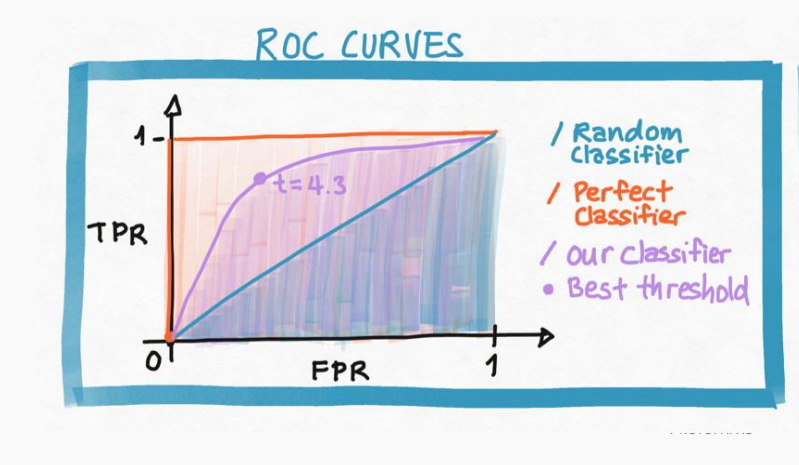

In [93]:
n = 11
print(train_captions[n])
Image.open(img_name_vector[n])

In [94]:
type(Image.open(img_name_vector[n]))

PIL.PngImagePlugin.PngImageFile

## Preprocess the images using InceptionV3
Next, we will use InceptionV3 (which is pretrained on Imagenet) to classify each image. We will extract features from the last convolutional layer.

First, we will convert the images into InceptionV3's expected format by:
* Resizing the image to 299px by 299px
* [Preprocess the images](https://cloud.google.com/tpu/docs/inception-v3-advanced#preprocessing_stage) using the [preprocess_input](https://www.tensorflow.org/api_docs/python/tf/keras/applications/inception_v3/preprocess_input) method to normalize the image so that it contains pixels in the range of -1 to 1, which matches the format of the images used to train InceptionV3.

In [95]:
def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.io.decode_png(img, channels=3)
    img = tf.keras.layers.Resizing(height=299, width=299)(img)
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    return img, image_path

## Initialize InceptionV3 and load the pretrained Imagenet weights

Now we'll create a tf.keras model where the output layer is the last convolutional layer in the InceptionV3 architecture. The shape of the output of this layer is ```8x8x2048```. We use the last convolutional layer because we are using attention in this example. We don't perform this initialization during training because it could become a bottleneck.

* We forward each image through the network and store the resulting vector in a dictionary (image_name --> feature_vector).
* After all the images are passed through the network, we save the dictionary to disk.


In [96]:
image_model = tf.keras.applications.InceptionV3(include_top=False,
                                                weights='imagenet')
new_input = image_model.input
hidden_layer = image_model.layers[-1].output

image_features_extract_model = tf.keras.Model(new_input, hidden_layer)
image_features_extract_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv2d_94 (Conv2D)             (None, None, None,   864         ['input_2[0][0]']                
                                32)                                                               
                                                                                                  
 batch_normalization_94 (BatchN  (None, None, None,   96         ['conv2d_94[0][0]']              
 ormalization)                  32)                                                         

## Caching the features extracted from InceptionV3

We will pre-process each image with InceptionV3 and cache the output to disk. Caching the output in RAM would be faster but also memory intensive, requiring 8 \* 8 \* 2048 floats per image. This might exceed the memory limitations of Colab (currently 12GB of memory).

In [97]:
# Get unique images
encode_train = img_name_vector

# Feel free to change batch_size according to your system configuration
image_dataset = tf.data.Dataset.from_tensor_slices(encode_train)
image_dataset = image_dataset.map(
  load_image, num_parallel_calls=tf.data.AUTOTUNE).batch(16)

for img, path in image_dataset:
  batch_features = image_features_extract_model(img)
  batch_features = tf.reshape(batch_features,
                              (batch_features.shape[0], -1, batch_features.shape[3]))

  for bf, p in zip(batch_features, path):
    path_of_feature = p.numpy().decode("utf-8")
    np.save(path_of_feature, bf.numpy())

## Preprocess and tokenize the captions

We will transform the text captions into integer sequences using the [TextVectorization](https://www.tensorflow.org/api_docs/python/tf/keras/layers/TextVectorization) layer, with the following steps:

* Use [adapt](https://www.tensorflow.org/api_docs/python/tf/keras/layers/TextVectorization#adapt) to iterate over all captions, split the captions into words, and compute a vocabulary of the top 10,000 words (to save memory).
* Tokenize all captions by mapping each word to its index in the vocabulary. All output sequences will be padded to length 50.
* Create word-to-index and index-to-word mappings to display results.

In [98]:
tmp = []
for ele in train_captions:
  tmp.append(len(ele.split()))
max(tmp)

52

In [99]:
np.mean(np.array(tmp))

16.25

In [100]:
caption_dataset = tf.data.Dataset.from_tensor_slices(train_captions)

# We will override the default standardization of TextVectorization to preserve
# "<>" characters, so we preserve the tokens for the <start> and <end>.
def standardize(inputs):
  inputs = tf.strings.lower(inputs)
  # return inputs
  return tf.strings.regex_replace(inputs,
                                  r"!\"#$%&\(\)\*\+.,-/:;=?@\[\\\]^_`{|}~", "")

# Max word count for a caption.
max_length = 30
# Use the top 5000 words for a vocabulary.
vocabulary_size = 2000
tokenizer = tf.keras.layers.TextVectorization(
    max_tokens=vocabulary_size,
    standardize=standardize,
    output_sequence_length=max_length)
# Learn the vocabulary from the caption data.
tokenizer.adapt(caption_dataset)

In [101]:
# # Pickle the config and weights
# pickle.dump({'config': tokenizer.get_config(),
#              'weights': tokenizer.get_weights()}
#             , open("/content/drive/MyDrive/Colab Notebooks/AI-3/Project/models/tokenizer.pkl", "wb"))

# # Later you can unpickle and use 
# # `config` to create object and 
# # `weights` to load the trained weights. 
# from_disk = pickle.load(open("/content/drive/MyDrive/Colab Notebooks/AI-3/Project/models/tokenizer.pkl", "rb"))
# tokenizer = tf.keras.layers.TextVectorization.from_config(from_disk['config'])
# # You have to call `adapt` with some dummy data (BUG in Keras)
# tokenizer.adapt(tf.data.Dataset.from_tensor_slices(["xyz"]))
# tokenizer.set_weights(from_disk['weights'])

In [102]:
# Create the tokenized vectors
cap_vector = caption_dataset.map(lambda x: tokenizer(x))

In [103]:
for ele in cap_vector:
  print(ele)
  break

tf.Tensor(
[  2  62 187 405 439   6 376 328  16 325   6 321   3   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0], shape=(30,), dtype=int64)


In [104]:
# Create mappings for words to indices and indices to words.
word_to_index = tf.keras.layers.StringLookup(
    mask_token="",
    vocabulary=tokenizer.get_vocabulary())
index_to_word = tf.keras.layers.StringLookup(
    mask_token="",
    vocabulary=tokenizer.get_vocabulary(),
    invert=True)

## Split the data into training and validation

In [105]:
img_to_cap_vector = collections.defaultdict(list)
for img, cap in zip(img_name_vector, cap_vector):
  img_to_cap_vector[img].append(cap)

# Create training and validation sets using an 80-20 split randomly.
img_keys = list(img_to_cap_vector.keys())
random.shuffle(img_keys)

slice_index = 95
img_name_train_keys, img_name_val_keys = img_keys[:slice_index], img_keys[slice_index:]

img_name_train = []
cap_train = []
for imgt in img_name_train_keys:
  capt_len = len(img_to_cap_vector[imgt])
  img_name_train.extend([imgt] * capt_len)
  cap_train.extend(img_to_cap_vector[imgt])

img_name_val = []
cap_val = []
for imgv in img_name_val_keys:
  capv_len = len(img_to_cap_vector[imgv])
  img_name_val.extend([imgv] * capv_len)
  cap_val.extend(img_to_cap_vector[imgv])

In [106]:
len(img_name_train), len(cap_train), len(img_name_val), len(cap_val)

(95, 95, 5, 5)

## Create a tf.data dataset for training


Our images and captions are ready! Next, let's create a `tf.data` dataset to use for training our model.

In [107]:
# Feel free to change these parameters according to your system's configuration

BATCH_SIZE = 32
BUFFER_SIZE = 1000
embedding_dim = 256
units = 512
num_steps = len(img_name_train) // BATCH_SIZE
# Shape of the vector extracted from InceptionV3 is (64, 2048)
# These two variables represent that vector shape
features_shape = 2048
attention_features_shape = 64

In [108]:
# Load the numpy files
def map_func(img_name, cap):
  img_tensor = np.load(img_name.decode('utf-8')+'.npy')
  return img_tensor, cap

In [109]:
dataset = tf.data.Dataset.from_tensor_slices((img_name_train, cap_train))

# Use map to load the numpy files in parallel
dataset = dataset.map(lambda item1, item2: tf.numpy_function(
          map_func, [item1, item2], [tf.float32, tf.int64]),
          num_parallel_calls=tf.data.AUTOTUNE)

# Shuffle and batch
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

## Visual Attention Model

The model architecture is inspired by the [Show, Attend and Tell](https://arxiv.org/pdf/1502.03044.pdf) paper.

* In this example, we extract the features from the lower convolutional layer of InceptionV3 giving us a vector of shape (8, 8, 2048).
* We squash that to a shape of (64, 2048).
* This vector is then passed through the CNN Encoder (which consists of a single Fully connected layer).
* The RNN (here LSTM) attends over the image to predict the next word.

In [110]:
class BahdanauAttention(tf.keras.Model):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, features, hidden):
    # features(CNN_encoder output) shape == (batch_size, 64, embedding_dim)

    # hidden shape == (batch_size, hidden_size)
    # hidden_with_time_axis shape == (batch_size, 1, hidden_size)
    hidden_with_time_axis = tf.expand_dims(hidden, 1)

    # attention_hidden_layer shape == (batch_size, 64, units)
    attention_hidden_layer = (tf.nn.tanh(self.W1(features) +
                                         self.W2(hidden_with_time_axis)))

    # score shape == (batch_size, 64, 1)
    # This gives you an unnormalized score for each image feature.
    score = self.V(attention_hidden_layer)

    # attention_weights shape == (batch_size, 64, 1)
    attention_weights = tf.nn.softmax(score, axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * features
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

In [111]:
class CNN_Encoder(tf.keras.Model):
    # Since you have already extracted the features and dumped it
    # This encoder passes those features through a Fully connected layer
    def __init__(self, embedding_dim):
        super(CNN_Encoder, self).__init__()
        # shape after fc == (batch_size, 64, embedding_dim)
        self.fc = tf.keras.layers.Dense(embedding_dim)

    def call(self, x):
        x = self.fc(x)
        x = tf.nn.relu(x)
        return x

In [112]:
class RNN_Decoder(tf.keras.Model):
  def __init__(self, embedding_dim, units, vocab_size):
    super(RNN_Decoder, self).__init__()
    self.units = units

    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.lstm1 = tf.keras.layers.LSTM(self.units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.lstm2 = tf.keras.layers.LSTM(self.units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.fc1 = tf.keras.layers.Dense(self.units)
    self.fc2 = tf.keras.layers.Dense(vocab_size)

    self.attention = BahdanauAttention(self.units)

  def call(self, x, features, hidden):
    # defining attention as a separate model
    context_vector, attention_weights = self.attention(features, hidden)

    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
    x = self.embedding(x)

    # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # passing the concatenated vector to the LSTM
    x = self.lstm1(x)
    output, state, _ = self.lstm2(x)

    # shape == (batch_size, max_length, hidden_size)
    x = self.fc1(output)

    # x shape == (batch_size * max_length, hidden_size)
    x = tf.reshape(x, (-1, x.shape[2]))

    # output shape == (batch_size * max_length, vocab)
    x = self.fc2(x)

    return x, state, attention_weights

  def reset_state(self, batch_size):
    return tf.zeros((batch_size, self.units))

In [113]:
encoder = CNN_Encoder(embedding_dim)
decoder = RNN_Decoder(embedding_dim, units, tokenizer.vocabulary_size())

In [114]:
optimizer = tf.keras.optimizers.RMSprop()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')


def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

## Checkpoint

In [115]:
# checkpoint_path = "/content/drive/MyDrive/Colab Notebooks/AI-3/Project/models/attention_model/"
# ckpt = tf.train.Checkpoint(encoder=encoder,
#                            decoder=decoder,
#                            optimizer=optimizer)
# ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

In [116]:
start_epoch = 0
# if ckpt_manager.latest_checkpoint:
#   start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])
#   # restoring the latest checkpoint in checkpoint_path
#   ckpt.restore(ckpt_manager.latest_checkpoint)

## Training

* We extract the features stored in the respective `.npy` files and then pass those features through the encoder.
* The encoder output, hidden state(initialized to 0) and the decoder input (which is the start token) is passed to the decoder.
* The decoder returns the predictions and the decoder hidden state.
* The decoder hidden state is then passed back into the model and the predictions are used to calculate the loss.
* Use teacher forcing to decide the next input to the decoder.
* Teacher forcing is the technique where the target word is passed as the next input to the decoder.
* The final step is to calculate the gradients and apply it to the optimizer and backpropagate.

In [117]:
# adding this in a separate cell because if you run the training cell
# many times, the loss_plot array will be reset
loss_plot = []

In [118]:

def train_step(img_tensor, target):
  loss = 0

  # initializing the hidden state for each batch
  # because the captions are not related from image to image
  hidden = decoder.reset_state(batch_size=target.shape[0])

  dec_input = tf.expand_dims([word_to_index('<start>')] * target.shape[0], 1)

  with tf.GradientTape() as tape:
      features = encoder(img_tensor)

      for i in range(1, target.shape[1]):
          # passing the features through the decoder
          predictions, hidden, _ = decoder(dec_input, features, hidden)

          loss += loss_function(target[:, i], predictions)

          # using teacher forcing
          dec_input = tf.expand_dims(target[:, i], 1)

  total_loss = (loss / int(target.shape[1]))

  trainable_variables = encoder.trainable_variables + decoder.trainable_variables

  gradients = tape.gradient(loss, trainable_variables)

  optimizer.apply_gradients(zip(gradients, trainable_variables))

  return loss, total_loss

In [119]:
EPOCHS = 40

for epoch in range(start_epoch, EPOCHS):
    start = time.time()
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss

        if batch % 50 == 0:
            average_batch_loss = batch_loss.numpy()/int(target.shape[1])
            print(f'Epoch {epoch+1} Batch {batch} Loss {average_batch_loss:.4f}')
    # storing the epoch end loss value to plot later
    loss_plot.append(total_loss / num_steps)

    # if epoch % 4 == 0:
    #   ckpt_manager.save()

    print(f'Epoch {epoch+1} Loss {total_loss/num_steps:.6f}')
    print(f'Time taken for 1 epoch {time.time()-start:.2f} sec\n')

Epoch 1 Batch 0 Loss 3.2247
Epoch 1 Loss 6.448400
Time taken for 1 epoch 2.83 sec

Epoch 2 Batch 0 Loss 2.9690
Epoch 2 Loss 4.173085
Time taken for 1 epoch 2.51 sec

Epoch 3 Batch 0 Loss 2.6612
Epoch 3 Loss 3.910617
Time taken for 1 epoch 2.47 sec

Epoch 4 Batch 0 Loss 2.4342
Epoch 4 Loss 3.866546
Time taken for 1 epoch 2.46 sec

Epoch 5 Batch 0 Loss 2.6689
Epoch 5 Loss 3.896370
Time taken for 1 epoch 2.47 sec

Epoch 6 Batch 0 Loss 2.5065
Epoch 6 Loss 3.822609
Time taken for 1 epoch 2.48 sec

Epoch 7 Batch 0 Loss 2.5044
Epoch 7 Loss 3.784788
Time taken for 1 epoch 2.60 sec

Epoch 8 Batch 0 Loss 2.6977
Epoch 8 Loss 3.740550
Time taken for 1 epoch 2.45 sec

Epoch 9 Batch 0 Loss 2.3521
Epoch 9 Loss 3.725722
Time taken for 1 epoch 2.47 sec

Epoch 10 Batch 0 Loss 2.5107
Epoch 10 Loss 3.709385
Time taken for 1 epoch 2.50 sec

Epoch 11 Batch 0 Loss 2.3604
Epoch 11 Loss 3.589847
Time taken for 1 epoch 2.47 sec

Epoch 12 Batch 0 Loss 2.5554
Epoch 12 Loss 3.512003
Time taken for 1 epoch 2.60 sec

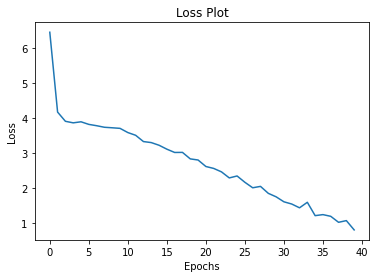

In [120]:
plt.plot(loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

## Caption!

* The evaluate function is similar to the training loop, except we don't use teacher forcing here. The input to the decoder at each time step is its previous predictions along with the hidden state and the encoder output.
* Stop predicting when the model predicts the end token.
* And store the attention weights for every time step.

In [121]:
def evaluate(image):
    attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = decoder.reset_state(batch_size=1)

    temp_input = tf.expand_dims(load_image(image)[0], 0)
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0],
                                                 -1,
                                                 img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([word_to_index('<start>')], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input,
                                                         features,
                                                         hidden)

        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy()
        predicted_word = tf.compat.as_text(index_to_word(predicted_id).numpy())
        result.append(predicted_word)

        if predicted_word == '<end>':
            return result, attention_plot

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot

In [122]:
def plot_attention(image, result, attention_plot):
    temp_image = np.array(Image.open(image))

    fig = plt.figure(figsize=(10, 10))

    len_result = len(result)
    for i in range(len_result):
        temp_att = np.resize(attention_plot[i], (8, 8))
        grid_size = max(int(np.ceil(len_result/2)), 2)
        ax = fig.add_subplot(grid_size, grid_size, i+1)
        ax.set_title(result[i])
        img = ax.imshow(temp_image)
        ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent())

    plt.tight_layout()
    plt.show()

Real Caption: <start> the graph exhibits how lasso regression coefficients or weights nullify to zero as an increasing function of regularization parameter alpha <end>
Prediction Caption: frequency alpha <end>


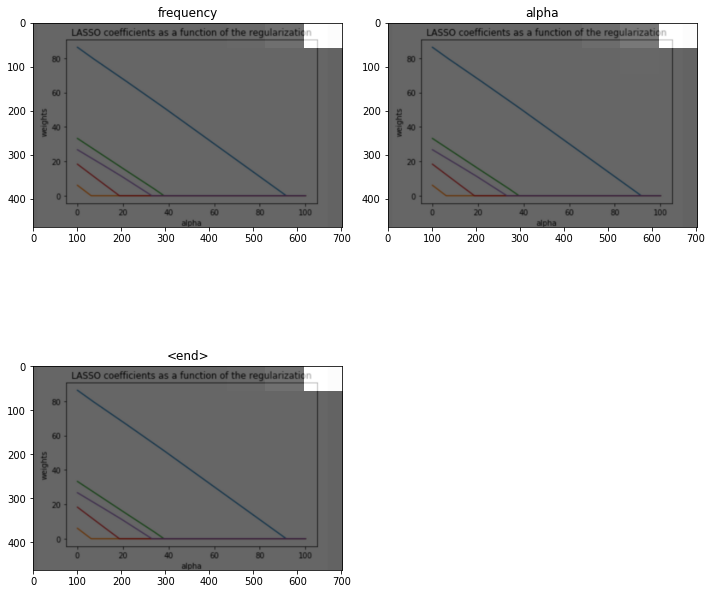

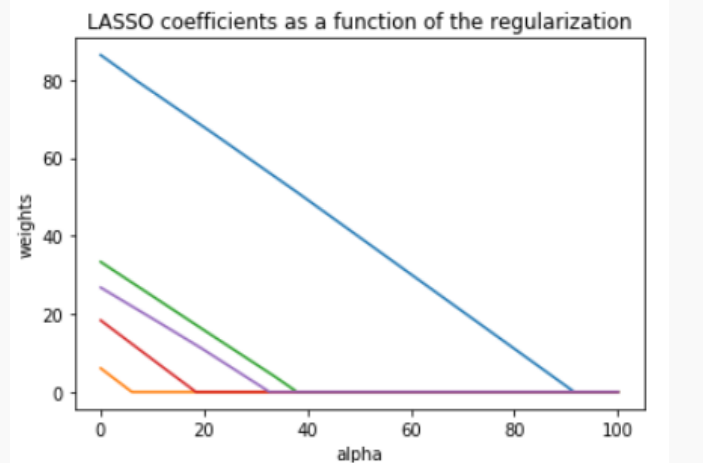

In [123]:
# captions on the validation set
rid = 0
image = img_name_val[rid]
real_caption = ' '.join([tf.compat.as_text(index_to_word(i).numpy())
                         for i in cap_val[rid] if i not in [0]])
result, attention_plot = evaluate(image)

print('Real Caption:', real_caption)
print('Prediction Caption:', ' '.join(result))
plot_attention(image, result, attention_plot)
Image.open(image)

In [124]:
reference = [[ele for ele in real_caption.split() if ele not in ['<start>', '<end>']]]
candidate = [ele for ele in result if ele not in ['<start>', '<end>']]
score = sentence_bleu(reference, candidate, smoothing_function=SmoothingFunction().method1)
print(f"BLEU-4 Score for the prediction: {score}")

BLEU-4 Score for the prediction: 1.8454070013176595e-05


In [125]:
print(f'Individual 1-gram: {sentence_bleu(reference, candidate, weights=(1, 0, 0, 0), smoothing_function=SmoothingFunction().method1)}')
print(f'Individual 2-gram: {sentence_bleu(reference, candidate, weights=(0, 1, 0, 0), smoothing_function=SmoothingFunction().method1)}')
print(f'Individual 3-gram: {sentence_bleu(reference, candidate, weights=(0, 0, 1, 0), smoothing_function=SmoothingFunction().method1)}')
print(f'Individual 4-gram: {sentence_bleu(reference, candidate, weights=(0, 0, 0, 1), smoothing_function=SmoothingFunction().method1)}')

Individual 1-gram: 6.170490204333978e-05
Individual 2-gram: 1.2340980408667958e-05
Individual 3-gram: 1.2340980408667958e-05
Individual 4-gram: 1.2340980408667958e-05


Real Caption: <start> scatter plot of data belonging to classes a and b after smote operation <end>
Prediction Caption: graph along with performance of the performance of the performance of the performance of the mse by comparing mse value of the predicted of height and dataset <end>


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  from ipykernel import kernelapp as app


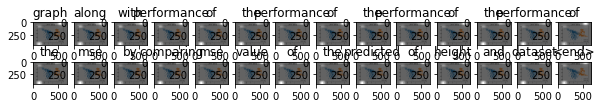

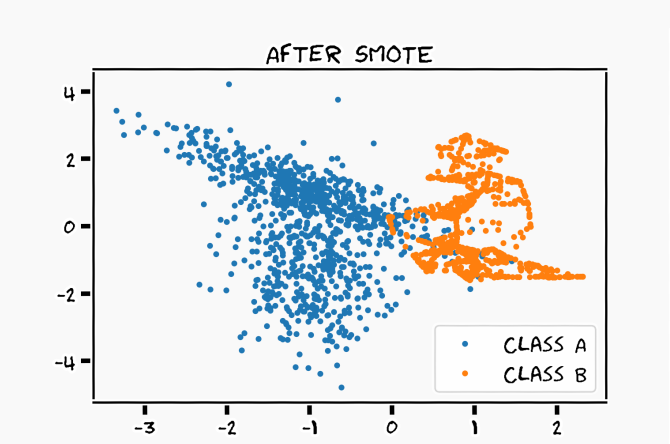

In [126]:
# captions on the validation set
rid = 1
image = img_name_val[rid]
real_caption = ' '.join([tf.compat.as_text(index_to_word(i).numpy())
                         for i in cap_val[rid] if i not in [0]])
result, attention_plot = evaluate(image)

print('Real Caption:', real_caption)
print('Prediction Caption:', ' '.join(result))
plot_attention(image, result, attention_plot)
Image.open(image)

In [127]:
reference = [[ele for ele in real_caption.split() if ele not in ['<start>', '<end>']]]
candidate = [ele for ele in result if ele not in ['<start>', '<end>']]
score = sentence_bleu(reference, candidate, smoothing_function=SmoothingFunction().method1)
print(f"BLEU-4 Score for the prediction: {score}")

BLEU-4 Score for the prediction: 0.008301095462822575


In [128]:
print(f'Individual 1-gram: {sentence_bleu(reference, candidate, weights=(1, 0, 0, 0), smoothing_function=SmoothingFunction().method1)}')
print(f'Individual 2-gram: {sentence_bleu(reference, candidate, weights=(0, 1, 0, 0), smoothing_function=SmoothingFunction().method1)}')
print(f'Individual 3-gram: {sentence_bleu(reference, candidate, weights=(0, 0, 1, 0), smoothing_function=SmoothingFunction().method1)}')
print(f'Individual 4-gram: {sentence_bleu(reference, candidate, weights=(0, 0, 0, 1), smoothing_function=SmoothingFunction().method1)}')

Individual 1-gram: 0.07407407407407407
Individual 2-gram: 0.003846153846153847
Individual 3-gram: 0.004000000000000002
Individual 4-gram: 0.0041666666666666675


Real Caption: <start> the different curves show t distributions for different values of it parameter v <end>
Prediction Caption: distributions of weights in estimating plot showing variable precistors recreation and regularized and test data values of bootstrap fruits error plot showing plot depicting and tv plot showing plot for


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  from ipykernel import kernelapp as app


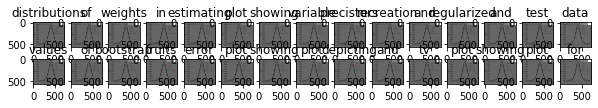

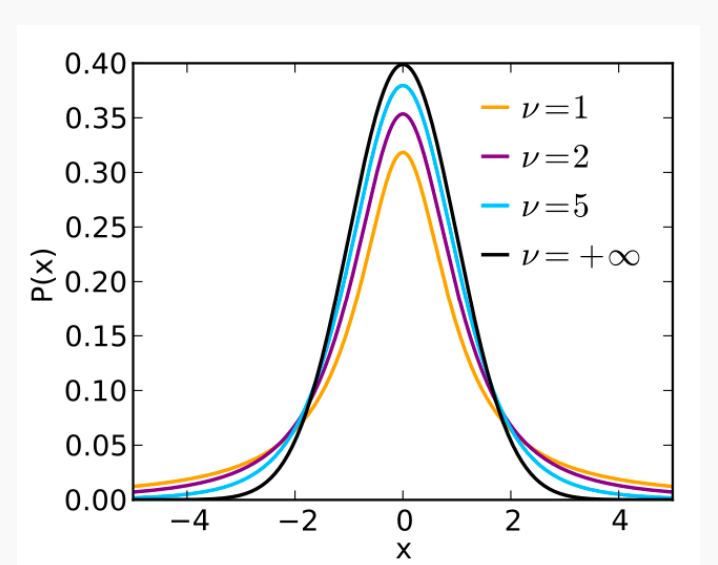

In [129]:
# captions on the validation set
rid = 2
image = img_name_val[rid]
real_caption = ' '.join([tf.compat.as_text(index_to_word(i).numpy())
                         for i in cap_val[rid] if i not in [0]])
result, attention_plot = evaluate(image)

print('Real Caption:', real_caption)
print('Prediction Caption:', ' '.join(result))
plot_attention(image, result, attention_plot)
Image.open(image)

In [130]:
reference = [[ele for ele in real_caption.split() if ele not in ['<start>', '<end>']]]
candidate = [ele for ele in result if ele not in ['<start>', '<end>']]
score = sentence_bleu(reference, candidate, smoothing_function=SmoothingFunction().method1)
print(f"BLEU-4 Score for the prediction: {score}")

BLEU-4 Score for the prediction: 0.015703799285850036


In [131]:
print(f'Individual 1-gram: {sentence_bleu(reference, candidate, weights=(1, 0, 0, 0), smoothing_function=SmoothingFunction().method1)}')
print(f'Individual 2-gram: {sentence_bleu(reference, candidate, weights=(0, 1, 0, 0), smoothing_function=SmoothingFunction().method1)}')
print(f'Individual 3-gram: {sentence_bleu(reference, candidate, weights=(0, 0, 1, 0), smoothing_function=SmoothingFunction().method1)}')
print(f'Individual 4-gram: {sentence_bleu(reference, candidate, weights=(0, 0, 0, 1), smoothing_function=SmoothingFunction().method1)}')

Individual 1-gram: 0.13333333333333333
Individual 2-gram: 0.03448275862068965
Individual 3-gram: 0.0035714285714285726
Individual 4-gram: 0.0037037037037037025


Real Caption: <start> histogram showing average business and users rating <end>
Prediction Caption: roc importance of convolutional neural networks showing plot depicting plot showing comparison of convolutional neural network <end>


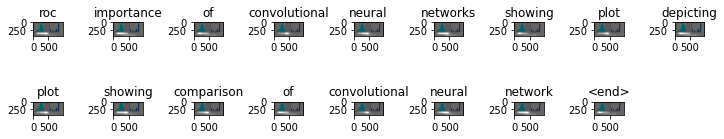

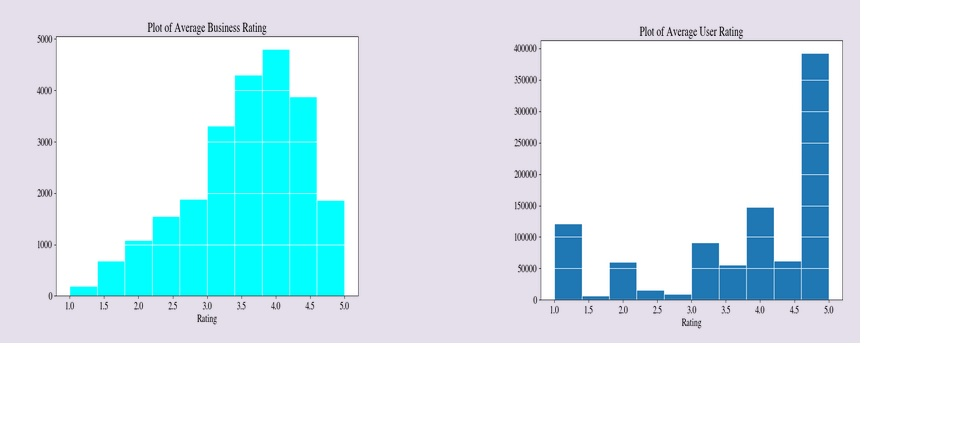

In [132]:
# captions on the validation set
rid = 3
image = img_name_val[rid]
real_caption = ' '.join([tf.compat.as_text(index_to_word(i).numpy())
                         for i in cap_val[rid] if i not in [0]])
result, attention_plot = evaluate(image)

print('Real Caption:', real_caption)
print('Prediction Caption:', ' '.join(result))
plot_attention(image, result, attention_plot)
Image.open(image)

In [133]:
reference = [[ele for ele in real_caption.split() if ele not in ['<start>', '<end>']]]
candidate = [ele for ele in result if ele not in ['<start>', '<end>']]
score = sentence_bleu(reference, candidate, smoothing_function=SmoothingFunction().method1)
print(f"BLEU-4 Score for the prediction: {score}")

BLEU-4 Score for the prediction: 0.012300686288463768


In [134]:
print(f'Individual 1-gram: {sentence_bleu(reference, candidate, weights=(1, 0, 0, 0), smoothing_function=SmoothingFunction().method1)}')
print(f'Individual 2-gram: {sentence_bleu(reference, candidate, weights=(0, 1, 0, 0), smoothing_function=SmoothingFunction().method1)}')
print(f'Individual 3-gram: {sentence_bleu(reference, candidate, weights=(0, 0, 1, 0), smoothing_function=SmoothingFunction().method1)}')
print(f'Individual 4-gram: {sentence_bleu(reference, candidate, weights=(0, 0, 0, 1), smoothing_function=SmoothingFunction().method1)}')

Individual 1-gram: 0.0625
Individual 2-gram: 0.006666666666666668
Individual 3-gram: 0.007142857142857146
Individual 4-gram: 0.007692307692307694


Real Caption: <start> plot showing comparison of different image and its autoencoder recreation and residuals of two images <end>
Prediction Caption: plot showing if linear plot may residuals <end>


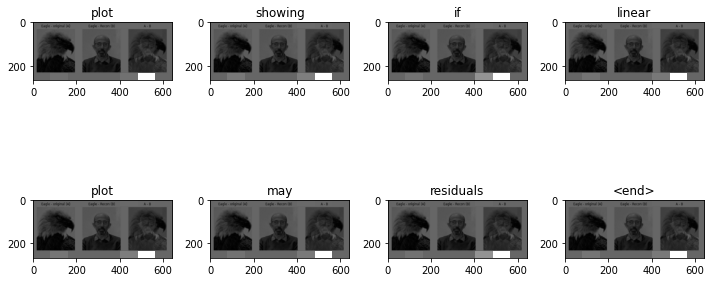

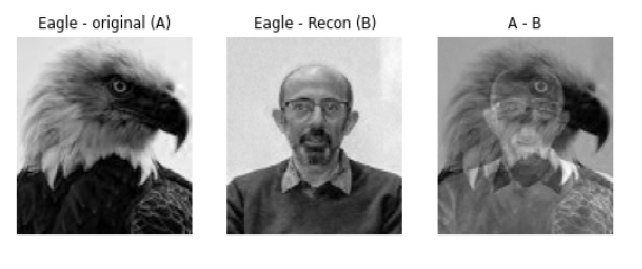

In [135]:
# captions on the validation set
rid = 4
image = img_name_val[rid]
real_caption = ' '.join([tf.compat.as_text(index_to_word(i).numpy())
                         for i in cap_val[rid] if i not in [0]])
result, attention_plot = evaluate(image)

print('Real Caption:', real_caption)
print('Prediction Caption:', ' '.join(result))
plot_attention(image, result, attention_plot)
Image.open(image)

In [136]:
reference = [[ele for ele in real_caption.split() if ele not in ['<start>', '<end>']]]
candidate = [ele for ele in result if ele not in ['<start>', '<end>']]
score = sentence_bleu(reference, candidate, smoothing_function=SmoothingFunction().method1)
print(f"BLEU-4 Score for the prediction: {score}")

BLEU-4 Score for the prediction: 0.024653236470203323


In [137]:
print(f'Individual 1-gram: {sentence_bleu(reference, candidate, weights=(1, 0, 0, 0), smoothing_function=SmoothingFunction().method1)}')
print(f'Individual 2-gram: {sentence_bleu(reference, candidate, weights=(0, 1, 0, 0), smoothing_function=SmoothingFunction().method1)}')
print(f'Individual 3-gram: {sentence_bleu(reference, candidate, weights=(0, 0, 1, 0), smoothing_function=SmoothingFunction().method1)}')
print(f'Individual 4-gram: {sentence_bleu(reference, candidate, weights=(0, 0, 0, 1), smoothing_function=SmoothingFunction().method1)}')

Individual 1-gram: 0.13667423885313018
Individual 2-gram: 0.053151092887328416
Individual 3-gram: 0.006378131146479409
Individual 4-gram: 0.00797266393309926


In [ ]:
# # Saving fine-tuned model weights
# encoder.save_weights("/content/drive/MyDrive/Colab Notebooks/AI-3/Project/models/attention_model/encoder_weights.ckpt")
# decoder.save_weights("/content/drive/MyDrive/Colab Notebooks/AI-3/Project/models/attention_model/decoder_weights.ckpt")